# Please find below the high-level structuring of python scripts in the attached folder. 

## Feature Engineering Script: 
* Feature Engineering_PPM  --- PPM, PRNR, Premium Freight

## Individual Model Scripts:
* regression approach PPM-v3
* regression approach prem freight 
* regression approach prnr
* Vulnerability Score Reg ----contains the feature engineering piece of vulnerability score as well

## Prod Scripts:
* Prod Script_V1   --- PPM, PRNR, Premium Freight
* Prod Script Vulnerability Score  ----- Vulnerability Score

## We need to run the prod scripts in the 1st week of every month

In [1]:
import pandas as pd
import numpy as np
import os
from dateutil.relativedelta import relativedelta
from datetime import date, datetime
import xgboost as xgb
import pickle
import cx_Oracle
os.chdir(r"C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\Supplier_Risk")

In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
os.chdir(r"C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\Supplier_Risk")

### Import Data Files

In [4]:
tns_dsn = cx_Oracle.makedsn('aamlxbidbp001.aam.net', 1525, service_name='BIDWPRD')
con_ORACLE = cx_Oracle.connect(user='PROD_AAM_RO', password='prodaamro', dsn=tns_dsn)

df = pd.read_sql_query("""select * from bi_dw.WC_SC_SUMMARY_V
                       where month >= 202101
                       """, con_ORACLE)

In [5]:
df_vb = pd.read_sql_query("""select b.supplier_name as vendor_name, third_party_id,  vulnerability_score
                            from 
                            (select third_party_id , max(score) vulnerability_score from rpa_kpmg_financial
                            group by third_party_id
                            ) a
                            join 
                            bi_dw.wc_sc_supplier_d b 
                            on a.third_party_id = b.affiliate_code 
                       """, con_ORACLE)

In [6]:
df_vb.dropna(subset = ["VULNERABILITY_SCORE"], inplace = True)

In [7]:
df_vb["VULNERABILITY_SCORE"] = df_vb["VULNERABILITY_SCORE"].astype(float)

In [8]:
# Download data from Orcale DB for prod
# Logic to collate data and filter suppliers to be implemented in the SQL script itself
# df = pd.read_csv(os.getcwd()+r"\Data Files\Feature Engineering Base.csv", encoding='latin-1')
df1 = pd.read_csv(os.getcwd()+r"\data\Mapping File Prod.csv", encoding='latin-1')

In [9]:
df = df.merge(df1, on = ["VENDOR_NAME","ORGANIZATION_CODE"], how='left')

In [10]:
df = df[df["ORG_TYPE"]!="Others2"]
df = df.groupby(['VENDOR_NAME', 'MONTH', 'TYPE']).sum().reset_index()

In [11]:
df = df.pivot(index = ['VENDOR_NAME','MONTH'], columns=['TYPE'], values = 'VAL').reset_index()

### Data Cleaning 

In [12]:
df["Qty Recd"].fillna(0, inplace = True)

In [13]:
df["QTY_RECD_FLAG"] = np.where((df["Qty Ordered"] != np.NaN) & (df["Qty Ordered"] !=0), df["Qty Recd"]/df["Qty Ordered"], np.NaN)
df["QTY_RECD_FLAG"] = np.where(df["QTY_RECD_FLAG"]>1, 1, df["QTY_RECD_FLAG"])

In [14]:
df["PPM Flag"] = np.where((df["PPM Qty Shipped"] != np.NaN) & (df["PPM Qty Shipped"] != 0), df["PPM Qty Rejected"]/df["PPM Qty Shipped"]*1000000, np.NaN)

In [15]:
df["MONTH"] = pd.to_datetime(df["MONTH"], format = '%Y%m').dt.date

### Define Current Month

In [22]:
cur_month

datetime.date(2023, 5, 1)

In [18]:
cur_month = date(date.today().year, date.today().month, 1)

# cur_month = date(2022,4,1)

In [19]:
df = df[df["MONTH"]>= cur_month - relativedelta(months=12)]

### QTY_RECD_FLAG to be aggregated w/o vendor name

In [20]:
target_df = df[["VENDOR_NAME"]]
target_df.drop_duplicates(inplace = True)

C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\globle_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
final_target_df = pd.DataFrame()


month = cur_month

target_df = df[["VENDOR_NAME"]]
target_df.drop_duplicates(inplace = True)


#Month on Month features
for z in np.arange(1,13,1):
    tmp = df[df["MONTH"]==month - relativedelta(months=z)].groupby(['VENDOR_NAME']).agg({ 
                "QTY_RECD_FLAG" : ['mean'],
                "Qty Ordered":['sum'], 
                "Qty Recd":['sum'],
                "PRNR" : ['sum'],
                "PREM FREIGHT" : ['sum'],
                "Cost Recovery" : ['sum'],
                "PPM Qty Rejected": ['sum'],
                "PPM Qty Shipped":['sum']
                })
    tmp.columns = [s + "_MOM_"  + str(z) for s in ["_".join(x) for x in tmp.columns.ravel()]]
    tmp.reset_index(inplace = True)
    target_df = target_df.merge(tmp, how = 'left', on = 'VENDOR_NAME')


#Quarterly features
for z in np.arange(1,13,3):
    tmp = df[(df["MONTH"]>=month - relativedelta(months=z+2))&(df["MONTH"]<=month - relativedelta(months=z))].groupby(['VENDOR_NAME']).agg({ 
                "QTY_RECD_FLAG" : ['max','min','std','mean'],
                "Qty Ordered":['max','min','std','mean', 'sum'], 
                "Qty Recd":['max','min','std','mean','sum'],
                "PRNR" : ['max','std','mean','sum'],
                "PREM FREIGHT" : ['max','std','mean','sum'],
                "Cost Recovery" : ['max','std','mean','sum'],
                "PPM Flag" : ['max','min','std','mean'], 
                "PPM Qty Rejected": ['max','min','std','mean', 'sum'],
                "PPM Qty Shipped":['max','min','std','mean', 'sum']
                })
    tmp.columns = [s + "_OQT_"  + str(z) for s in ["_".join(x) for x in tmp.columns.ravel()]]
    tmp.reset_index(inplace = True)
    
    for z in [x for x in tmp.columns if "PPM Qty Shipped_sum" in x]:
        tmp[z.replace("PPM Qty Shipped_sum","PPM_Agg_Flag")] = np.where((tmp[z]!= np.NaN) & (tmp[z]!= 0), np.round(tmp[z.replace("Shipped","Rejected")]/tmp[z]*1000000), np.NaN)
        
    for z in [x for x in tmp.columns if "Qty Ordered_sum" in x]:
        tmp[z.replace("Qty Ordered_sum","Qty Recd_percent_Agg")] = np.where((tmp[z]!= np.NaN) & (tmp[z]!= 0), tmp[z.replace("Ordered","Recd")]/tmp[z]*100, np.NaN) 


    target_df = target_df.merge(tmp, how = 'left', on = 'VENDOR_NAME')


final_target_df = pd.concat([final_target_df, target_df])

C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\globle_env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# Merge with Vulnerability DF to map target score

In [23]:
final_target_df = final_target_df.merge(df_vb, how = 'inner', on = 'VENDOR_NAME')

In [24]:
final_target_df

,VENDOR_NAME,QTY_RECD_FLAG_mean_MOM_1,Qty Ordered_sum_MOM_1,Qty Recd_sum_MOM_1,PRNR_sum_MOM_1,PREM FREIGHT_sum_MOM_1,Cost Recovery_sum_MOM_1,PPM Qty Rejected_sum_MOM_1,PPM Qty Shipped_sum_MOM_1,QTY_RECD_FLAG_mean_MOM_2,...,PPM Qty Rejected_sum_OQT_10,PPM Qty Shipped_max_OQT_10,PPM Qty Shipped_min_OQT_10,PPM Qty Shipped_std_OQT_10,PPM Qty Shipped_mean_OQT_10,PPM Qty Shipped_sum_OQT_10,PPM_Agg_Flag_OQT_10,Qty Recd_percent_Agg_OQT_10,THIRD_PARTY_ID,VULNERABILITY_SCORE
0,AALBERTS T S/ IMPREGLON,1.000000,1080.0,1080.0,0.0,0.0,0.0,0.0,1080.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1022,25.62
1,AAM AUTO COMPONENT (INDIA) PRIVATE LIMITED,0.484184,41193.0,19945.0,0.0,0.0,0.0,0.0,46446.0,0.394985,...,0.0,5958.0,3580.0,1215.834830,4.915667e+03,14747.0,0.0,445.150225,1,53.47
2,AAM DO BRASIL LTDA,0.000000,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,18200.0,6000.0,6296.030495,1.120000e+04,33600.0,0.0,95.586854,1,53.47
3,AAM GERMANY GMBH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.0,4086.0,4086.0,NaN,4.086000e+03,4086.0,0.0,100.000000,1,53.47
4,AAM INTERNATIONAL S A R L,1.000000,1213578.0,1359922.0,0.0,0.0,0.0,4.0,1368880.0,1.000000,...,150.0,1471802.0,1372300.0,52158.659121,1.413007e+06,4239022.0,35.0,103.616659,1,53.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,ZHEJIANG SHUANGHUAN DRIVELINE CO LTD,0.927224,48120.0,44618.0,0.0,0.0,0.0,0.0,47985.0,0.941717,...,6.0,70494.0,47289.0,11690.621041,5.971867e+04,179156.0,33.0,98.601019,1026,22.55
573,ZHONGDING USA INC,1.000000,54000.0,69900.0,0.0,0.0,0.0,0.0,69900.0,0.899213,...,0.0,69900.0,57500.0,6453.164598,6.473333e+04,194200.0,0.0,103.407881,1192,29.80
574,ZOUPING TIANSHENG METAL TECHNOLOGY CO LTD,0.936138,15972.0,14952.0,0.0,0.0,0.0,0.0,15972.0,0.959767,...,0.0,34212.0,20832.0,7193.200122,2.904800e+04,87144.0,0.0,101.691419,82,38.05
575,ZWZ BEARING USA,0.974194,178560.0,173952.0,0.0,0.0,0.0,0.0,176256.0,1.000000,...,0.0,185040.0,109008.0,42704.680399,1.582560e+05,474768.0,0.0,100.000000,75,95.00


In [25]:
final_target_df.VULNERABILITY_SCORE

0      25.62
1      53.47
2      53.47
3      53.47
4      53.47
       ...  
572    22.55
573    29.80
574    38.05
575    95.00
576    95.00
Name: VULNERABILITY_SCORE, Length: 577, dtype: float64

# Train Model

In [26]:
target = "VULNERABILITY_SCORE"

In [27]:
seed = 1

df_train, df_test = train_test_split(final_target_df, test_size= 0.01, random_state=seed)
df_train, df_valid = train_test_split(df_train, test_size= 0.2, random_state=seed)

In [28]:
X_train=df_train.drop(["VENDOR_NAME", "THIRD_PARTY_ID", target] ,axis=1)
y_train=df_train[target]

X_valid=df_valid.drop(["VENDOR_NAME", "THIRD_PARTY_ID", target] ,axis=1)
y_valid=df_valid[target]

X_test=df_test.drop(["VENDOR_NAME", "THIRD_PARTY_ID", target] ,axis=1)
y_test=df_test[target]

In [29]:
seed = 25522

##event rate
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("\n validation set shape:",X_valid.shape)


Event rate in train set : 4,136.26%

 Train set shape: (456, 264)

Event rate in test set : 2,846.00%

 Test set shape: (6, 264)

Event rate in validation set : 4,149.78%

 validation set shape: (115, 264)


In [30]:
## Variable importance
def fimportances(xc, predictors):
    importances = pd.DataFrame({'predictor': predictors, 'importance': xc.feature_importances_})
    importances = importances[importances['importance'] > 0]
    importances.sort_values(by='importance', ascending=False, inplace=True)
    importances.reset_index(inplace=True, drop=True)
    importances = importances[['predictor', 'importance']]
    return importances

In [31]:
xgb_model = xgb.XGBRegressor(max_depth = 3,
              learning_rate = 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              nthread = -1, 
              n_estimators = 200              
              )

evals=[(X_train, np.ravel(y_train)),(X_valid, np.ravel(y_valid))]

bst = xgb_model.fit(X_train, np.ravel(y_train), eval_metric="rmse", eval_set=evals, early_stopping_rounds=40,  verbose=False)

In [32]:
imp = fimportances(bst,X_train.columns)

In [33]:
bst1 = bst
X_train_1 = X_train
X_valid_1 = X_valid
select_X_train = X_train_1

dic_imp = {"n":[imp.shape[0]],"Rmse Train":[0],"Rmse Test":[0],"Predictors":[list(imp['predictor'])]}

while(select_X_train.shape[1] > 3):
    select_X_train = X_train_1[list(imp['predictor'])[:-2]]
    select_X_valid = X_valid_1[list(imp['predictor'])[:-2]]
    xgb_model = xgb.XGBRegressor(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              nthread = -1, 
              n_estimators = 200              
              )

    evals=[(select_X_train, np.ravel(y_train)),(select_X_valid, np.ravel(y_valid))]

    bst = xgb_model.fit(select_X_train, np.ravel(y_train), eval_metric="rmse", eval_set=evals,
                        early_stopping_rounds=40   ,  verbose=False)
    
    ypred_train = bst.predict(select_X_train)
    ypred_test  = bst.predict(select_X_valid)
    
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, ypred_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_valid, ypred_test))

    
    print("Columns Remaining : %d , rmse_train: %f,rmse_test: %f "%(select_X_train.shape[1],rmse_train,rmse_test))
    
    dic_imp['n'].append(imp.shape[0])
    dic_imp['Rmse Train'].append(rmse_train)
    dic_imp['Rmse Test'].append(rmse_test)
    dic_imp['Predictors'].append(list(imp['predictor']))
    
    imp = fimportances(bst,select_X_train.columns)

Columns Remaining : 166 , rmse_train: 19.060592,rmse_test: 21.417261 
Columns Remaining : 152 , rmse_train: 19.058771,rmse_test: 21.569503 
Columns Remaining : 142 , rmse_train: 19.074101,rmse_test: 21.545302 
Columns Remaining : 131 , rmse_train: 19.114704,rmse_test: 21.701942 
Columns Remaining : 125 , rmse_train: 19.033219,rmse_test: 21.534737 
Columns Remaining : 122 , rmse_train: 19.061221,rmse_test: 21.522679 
Columns Remaining : 120 , rmse_train: 19.043493,rmse_test: 21.611762 
Columns Remaining : 117 , rmse_train: 19.036005,rmse_test: 21.509496 
Columns Remaining : 115 , rmse_train: 19.033222,rmse_test: 21.541889 
Columns Remaining : 113 , rmse_train: 19.037310,rmse_test: 21.595670 
Columns Remaining : 111 , rmse_train: 19.062841,rmse_test: 21.626906 
Columns Remaining : 109 , rmse_train: 19.117348,rmse_test: 21.493102 
Columns Remaining : 106 , rmse_train: 19.052954,rmse_test: 21.549963 
Columns Remaining : 104 , rmse_train: 19.092757,rmse_test: 21.637878 
Columns Remaining : 

In [34]:
df_imp =pd.DataFrame(dic_imp)

In [35]:
df_imp

,n,Rmse Train,Rmse Test,Predictors
0,168,0.000000,0.000000,"[Qty Ordered_mean_OQT_1, Qty Recd_mean_OQT_4, ..."
1,168,19.060592,21.417261,"[Qty Ordered_mean_OQT_1, Qty Recd_mean_OQT_4, ..."
2,154,19.058771,21.569503,"[PPM Flag_max_OQT_7, PPM Qty Shipped_sum_MOM_8..."
3,144,19.074101,21.545302,"[PPM Flag_mean_OQT_4, Qty Ordered_min_OQT_7, Q..."
4,133,19.114704,21.701942,"[Qty Ordered_mean_OQT_7, PPM Flag_max_OQT_7, P..."
...,...,...,...,...
60,12,20.094708,21.830762,"[PRNR_mean_OQT_10, Qty Recd_sum_MOM_9, Qty Ord..."
61,10,20.336294,21.869420,"[PRNR_sum_MOM_12, Qty Ordered_std_OQT_10, PPM ..."
62,8,20.375088,21.719894,"[Qty Ordered_std_OQT_10, Qty Ordered_mean_OQT_..."
63,6,20.632726,21.812043,"[Qty Ordered_mean_OQT_4, PPM Qty Shipped_sum_M..."


In [38]:
selected_vars = list(df_imp[df_imp['n']==18]["Predictors"])

In [39]:
selected_vars

[['PPM Qty Shipped_sum_MOM_8',
  'Qty Ordered_mean_OQT_4',
  'PPM Flag_max_OQT_7',
  'Qty Recd_min_OQT_7',
  'PRNR_mean_OQT_10',
  'Qty Ordered_std_OQT_10',
  'Qty Ordered_max_OQT_4',
  'PPM Flag_mean_OQT_7',
  'Qty Ordered_sum_MOM_2',
  'PRNR_sum_MOM_12',
  'PPM Qty Rejected_sum_MOM_4',
  'Qty Recd_sum_MOM_9',
  'PPM Qty Shipped_std_OQT_1',
  'Qty Recd_percent_Agg_OQT_4',
  'Qty Ordered_min_OQT_4',
  'PPM Qty Shipped_sum_MOM_9',
  'Qty Recd_sum_MOM_12',
  'PPM Flag_max_OQT_4']]

In [40]:
filename = 'data/Vulnerability_selected_cols.sav'
pickle.dump(selected_vars[0], open(filename, 'wb'))

In [41]:
X_train_2=X_train[selected_vars[0]]
X_test_2=X_test[selected_vars[0]]
X_valid_2=X_valid[selected_vars[0]]


print("\n Train shape:",X_train_2.shape,"\n Test shape:",X_test_2.shape,"\n Validation shape:",X_valid_2.shape)


 Train shape: (456, 18) 
 Test shape: (6, 18) 
 Validation shape: (115, 18)


In [42]:
# set model parameters 
missing_value=None; cpu=-1; early_stopping_round=40; split_random_state=None
kfolds = StratifiedKFold(6, random_state=1, shuffle = True)

In [43]:
## XGB model##
param_grid = {'max_depth': list(range(1, 6)),
              'learning_rate': np.arange(0.001, 0.02, 0.001),
              'subsample': np.arange(0.4, 0.7,0.05),
              'min_child_weight': np.arange(1, 25, 3),
              'colsample_bytree': np.arange(0.5, 0.75, 0.05),
              'scale_pos_weight' :np.arange(5, 40, 2), 
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5]
            }

if X_train_2.shape[1] == 1:
    param_grid['colsample_bytree'] = [1]
    
param_dist = {'nthread': cpu, 'n_estimators': 200}
xgb_model = xgb.XGBRegressor(**param_dist)

##random search XGB    
clf = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring='neg_mean_absolute_error', n_iter=50,
                         random_state=40, cv=6,error_score=0, return_train_score =True)
print("Randomized search..")
search_time_start = time.time()
clf.fit(X_train_2, np.ravel(y_train), verbose = 1)
print("Randomized search time:", time.time() - search_time_start)
params = clf.best_params_

dic=clf.cv_results_

params_bst = params
params_tbl = pd.DataFrame(columns=list(params_bst.keys()))  
params_tbl.loc['0'] = [params_bst[k] for k in params_tbl.columns]

print("Best score: {}".format(clf.best_score_))
print("Best params: ")
for param_name in sorted(params_bst.keys()):
    print('%s: %r' % (param_name, params_bst[param_name]))

params.update(param_dist)
xgb_model = xgb.XGBClassifier(**params)

Randomized search..
Randomized search time: 33.790640354156494
Best score: -17.425129665073595
Best params: 
colsample_bytree: 0.55
learning_rate: 0.019000000000000003
max_depth: 3
min_child_weight: 7
reg_alpha: 1
reg_lambda: 5
scale_pos_weight: 29
subsample: 0.55


In [44]:
pd.Series(dic['mean_train_score']).to_csv("mean_train_rmse_vulnerability_reg.csv")

In [45]:
pd.Series(dic['mean_test_score']).to_csv("mean_test_rmse_vulnerability_reg.csv")

In [46]:
params

{'subsample': 0.55,
 'scale_pos_weight': 29,
 'reg_lambda': 5,
 'reg_alpha': 1,
 'min_child_weight': 7,
 'max_depth': 3,
 'learning_rate': 0.019000000000000003,
 'colsample_bytree': 0.55,
 'nthread': -1,
 'n_estimators': 200}

In [47]:
# colsample_bytree: 0.7000000000000002
# learning_rate: 0.016
# max_depth: 5
# min_child_weight: 10
# scale_pos_weight: 5
# subsample: 0.6pd.DataFrame(dic['params']).to_csv("params_mesdq.csv")

In [48]:
xgb_model = xgb.XGBRegressor(max_depth = 3,
              learning_rate= 0.02,
              subsample= 0.55,
              min_child_weight= 7,
              colsample_bytree= 0.55,
              scale_pos_weight = 29,
              nthread = -1, 
              n_estimators = 200, 
                reg_lambda = 5,
                reg_alpha = 1
             ) 

In [49]:
# cross validation gini
def xgboost(X_tr,X_ts,y_tr,y_ts):
    evals=[(X_tr, np.ravel(y_tr)),(X_ts, np.ravel(y_ts))]

    bst = xgb_model.fit(X_tr, np.ravel(y_tr), eval_metric="rmse", eval_set=evals,
                        early_stopping_rounds=early_stopping_round   ,  verbose=False)

    if early_stopping_round is None:
        ypred_train = bst.predict(X_tr)
        ypred_test = bst.predict(X_ts)
    else:
        ypred_train = bst.predict(X_tr, ntree_limit=bst.best_ntree_limit)
        ypred_test = bst.predict(X_ts, ntree_limit=bst.best_ntree_limit)

    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, ypred_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_valid, ypred_test))

    return bst,rmse_train,rmse_test,ypred_train,ypred_test

In [50]:
## run xgboost
bst,rmse_train,rmse_test,ypred_train,ypred_test=xgboost(X_train_2, X_valid_2, y_train, y_valid)

##Model performance on sample
print("RMSE TRAIN:",rmse_train )
print("\nRMSE Validation:",rmse_test )


RMSE TRAIN: 17.918489468248044

RMSE Validation: 21.242138911467123


C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\globle_env\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [51]:
X_train_2.columns

Index(['PPM Qty Shipped_sum_MOM_8', 'Qty Ordered_mean_OQT_4',
       'PPM Flag_max_OQT_7', 'Qty Recd_min_OQT_7', 'PRNR_mean_OQT_10',
       'Qty Ordered_std_OQT_10', 'Qty Ordered_max_OQT_4',
       'PPM Flag_mean_OQT_7', 'Qty Ordered_sum_MOM_2', 'PRNR_sum_MOM_12',
       'PPM Qty Rejected_sum_MOM_4', 'Qty Recd_sum_MOM_9',
       'PPM Qty Shipped_std_OQT_1', 'Qty Recd_percent_Agg_OQT_4',
       'Qty Ordered_min_OQT_4', 'PPM Qty Shipped_sum_MOM_9',
       'Qty Recd_sum_MOM_12', 'PPM Flag_max_OQT_4'],
      dtype='object')

In [52]:
#ypred_test = bst.predict_proba(X_test_2.drop(columns=['act','pred']), ntree_limit=bst.best_ntree_limit)[:, 1]
ypred_test = bst.predict(X_test_2, ntree_limit=bst.best_ntree_limit)
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, ypred_test))
print("RMSE Test",rmse_test*2-1)

RMSE Test 42.22971396409784


C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\globle_env\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [53]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.to_csv("xgb_vulnerability_reg.csv",index=0)

In [54]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.head(50)

,predictor,importance
0,Qty Ordered_max_OQT_4,0.065752
1,Qty Recd_min_OQT_7,0.065313
2,PPM Qty Rejected_sum_MOM_4,0.061951
3,Qty Ordered_mean_OQT_4,0.058612
4,Qty Recd_sum_MOM_9,0.058387
5,Qty Ordered_std_OQT_10,0.057933
6,PRNR_sum_MOM_12,0.056759
7,Qty Recd_percent_Agg_OQT_4,0.056267
8,PPM Qty Shipped_std_OQT_1,0.055860
9,Qty Ordered_min_OQT_4,0.055664


In [55]:
## save the model 
pickle.dump(bst, open("xgb_vulnerability_reg", "wb"))
##Score the dataset
final_target_df["PRED"] =  bst.predict(final_target_df[selected_vars[0]], ntree_limit=bst.best_ntree_limit)

final_target_df.to_csv(r"xgb_vulnerability_pred_reg.csv")

C:\Users\Kumbhar\OneDrive - American Axle & Manufacturing, Inc\AAM\globle_env\lib\site-packages\xgboost\core.py:108: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [56]:
# retrieve performance metrics
results = bst.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

Text(0.5, 1.0, 'XGBoost AUC')

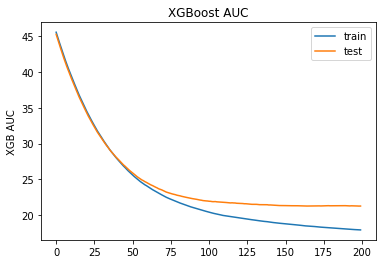

In [57]:
# plot auc wrt estimators
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='train')
ax.plot(x_axis, results['validation_1']['rmse'], label='test')

ax.legend()
plt.ylabel('XGB AUC')
plt.title('XGBoost AUC')